# Unit10｜降維與可視化：PCA（可解釋）+ t-SNE/UMAP（看群就好）

對應講義：`Part_3/Unit10_Dimensionality_Reduction_PCA_UMAP.md`


In [1]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
os.makedirs('Unit10_Results', exist_ok=True)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
Working dir: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_3


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap

print("Imports OK")

Imports OK


## 1. 建立示範用製程模式資料（自洽可重跑）

In [4]:
features = ['T_reactor','P_reactor','F_feed','C_coolant','Reflux_ratio','Energy_kW']

# Define RNG for reproducibility
RNG = np.random.default_rng(42)

means = np.array([
    [180, 10.0, 100, 25, 1.8, 800],
    [190, 10.5, 105, 26, 2.1, 860],
    [175,  9.6,  95, 24, 1.6, 760],
    [185, 10.2, 110, 27, 1.9, 900],
], dtype=float)

base_cov = np.array([
    [9.0,  0.8,  4.0,  0.5,  0.2,  8.0],
    [0.8,  0.2,  0.6,  0.1,  0.05, 1.2],
    [4.0,  0.6, 25.0,  0.4,  0.15, 6.0],
    [0.5,  0.1,  0.4,  0.6,  0.03, 0.8],
    [0.2,  0.05, 0.15, 0.03, 0.04, 0.6],
    [8.0,  1.2,  6.0,  0.8,  0.6, 20.0],
], dtype=float)

X = []
y = []
for m in range(4):
    X_m = RNG.multivariate_normal(mean=means[m], cov=base_cov, size=250)
    X.append(X_m)
    y.extend([m]*len(X_m))

X = np.vstack(X)
y = np.array(y)

df = pd.DataFrame(X, columns=features)

scaler = StandardScaler()
Xz = scaler.fit_transform(df.values)
print('data shape:', Xz.shape)


data shape: (1000, 6)


## 2. PCA：scree plot（你需要幾個 PC？）

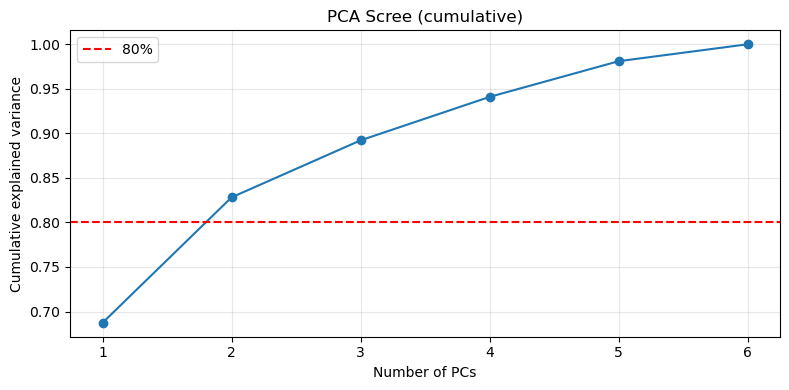

Saved: Unit10_Results/01_pca_scree.png


In [5]:
pca_full = PCA(random_state=42)
Z = pca_full.fit_transform(Xz)
exp = pca_full.explained_variance_ratio_

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(exp)+1), np.cumsum(exp), marker='o')
plt.axhline(0.8, color='red', linestyle='--', label='80%')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Scree (cumulative)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('./Unit10_Results/01_pca_scree.png', dpi=150)
plt.show()
print('Saved: Unit10_Results/01_pca_scree.png')


## 3. PCA：score plot（樣本地圖）

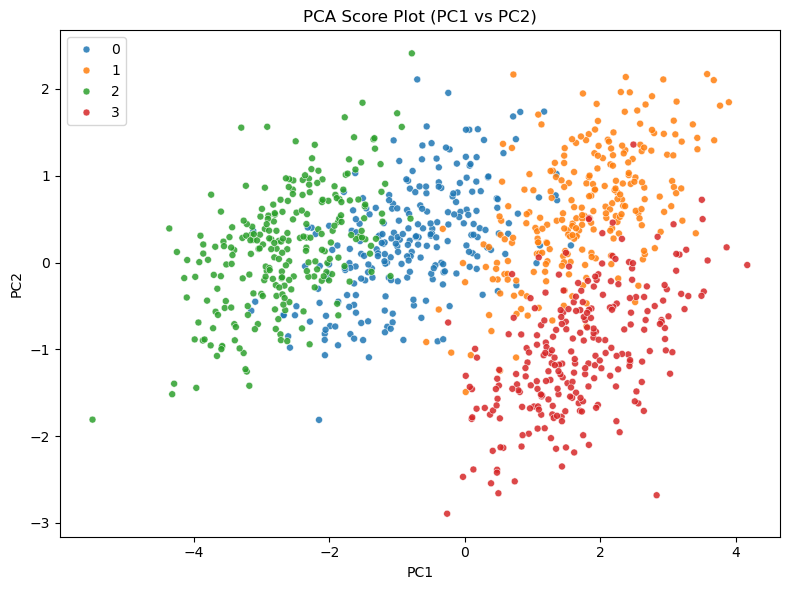

Saved: Unit10_Results/02_pca_scores.png
Explained variance ratio: [0.687 0.141]


In [6]:
pca2 = PCA(n_components=2, random_state=42)
Z2 = pca2.fit_transform(Xz)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z2[:,0], y=Z2[:,1], hue=y, palette='tab10', s=25, alpha=0.85)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Score Plot (PC1 vs PC2)')
plt.tight_layout()
plt.savefig('./Unit10_Results/02_pca_scores.png', dpi=150)
plt.show()
print('Saved: Unit10_Results/02_pca_scores.png')

print('Explained variance ratio:', pca2.explained_variance_ratio_.round(3))


## 4. PCA：loadings（變數貢獻）

,PC1,PC2
T_reactor,0.439525,0.183586
Energy_kW,0.438493,-0.356882
C_coolant,0.407387,-0.350013
P_reactor,0.395834,0.493785
Reflux_ratio,0.383191,0.513805
F_feed,0.380864,-0.456730


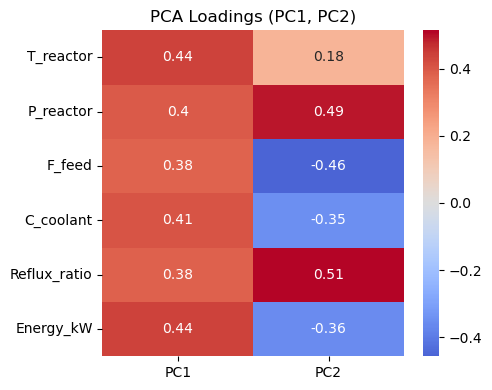

Saved: Unit10_Results/03_pca_loadings.png


In [7]:
loadings = pd.DataFrame(pca2.components_.T, index=features, columns=['PC1','PC2'])
display(loadings.sort_values('PC1', key=np.abs, ascending=False))

plt.figure(figsize=(5, 4))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings (PC1, PC2)')
plt.tight_layout()
plt.savefig('./Unit10_Results/03_pca_loadings.png', dpi=150)
plt.show()
print('Saved: Unit10_Results/03_pca_loadings.png')


## 5. Biplot（score + loading 箭頭）

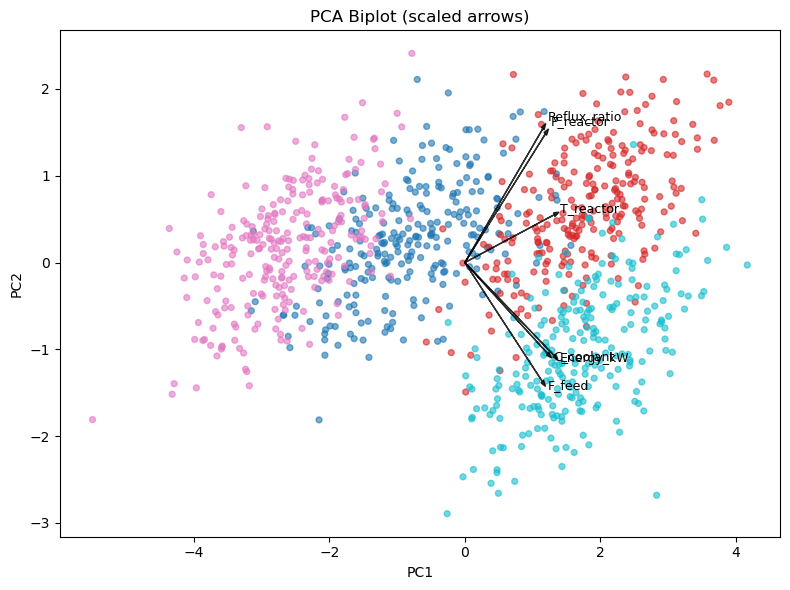

Saved: Unit10_Results/04_pca_biplot.png


In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(Z2[:,0], Z2[:,1], c=y, cmap='tab10', s=18, alpha=0.6)

for f in features:
    plt.arrow(0, 0, loadings.loc[f,'PC1']*3, loadings.loc[f,'PC2']*3,
              color='black', alpha=0.8, head_width=0.05)
    plt.text(loadings.loc[f,'PC1']*3.2, loadings.loc[f,'PC2']*3.2, f, fontsize=9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot (scaled arrows)')
plt.tight_layout()
plt.savefig('./Unit10_Results/04_pca_biplot.png', dpi=150)
plt.show()
print('Saved: Unit10_Results/04_pca_biplot.png')


## 5.1 身歷其境：把 PC1/PC2 翻譯成工程語言（模板）

目標：你要能把 score plot 的漂移，翻成「哪幾個 tag 在推動變動」與「現場要做什麼」。


In [9]:
# 5.1.1 Top loadings：找出每個 PC 的關鍵 tag

def top_loadings(load_df, pc='PC1', top_n=3):
    s = load_df[pc].copy()
    return s.reindex(s.abs().sort_values(ascending=False).index).head(top_n)

print('Top loadings for PC1:')
display(top_loadings(loadings, 'PC1', 4))

print('Top loadings for PC2:')
display(top_loadings(loadings, 'PC2', 4))


Top loadings for PC1:


T_reactor    0.439525
Energy_kW    0.438493
C_coolant    0.407387
P_reactor    0.395834
Name: PC1, dtype: float64

Top loadings for PC2:


Reflux_ratio    0.513805
P_reactor       0.493785
F_feed         -0.456730
Energy_kW      -0.356882
Name: PC2, dtype: float64

In [10]:
# 5.1.2 工程命名（示範）：請依你的資料替換成更貼近現場的命名

pc_name = {
    'PC1': 'Energy / Severity axis (示範)',
    'PC2': 'Reflux / Separation axis (示範)',
}

print('Suggested names:')
for k,v in pc_name.items():
    print(k, '->', v)

# 你可以把這段輸出貼進報告


Suggested names:
PC1 -> Energy / Severity axis (示範)
PC2 -> Reflux / Separation axis (示範)


In [11]:
# 5.1.3 行動建議（示範）：如果新資料在 score plot 往 +PC1 漂移，代表什麼？

# 用 loadings 的符號做一個最小版敘述（示範）
pc = 'PC1'
key = top_loadings(loadings, pc, 3)
msg = []
for tag, w in key.items():
    direction = 'increase' if w > 0 else 'decrease'
    msg.append(f'- {tag}: {direction} (loading={w:.3f})')

print(f'If score moves toward +{pc}:')
print('Key drivers may be:')
print(''.join(msg))
print('Operational suggestion (example):')
print('- verify data quality (missing/outliers)')
print('- check if operating window changed (raw material / fouling / controller tuning)')
print('- if persistent, switch to conservative mode / trigger sampling / escalate to unit engineer')


If score moves toward +PC1:
Key drivers may be:
- T_reactor: increase (loading=0.440)- Energy_kW: increase (loading=0.438)- C_coolant: increase (loading=0.407)
Operational suggestion (example):
- verify data quality (missing/outliers)
- check if operating window changed (raw material / fouling / controller tuning)
- if persistent, switch to conservative mode / trigger sampling / escalate to unit engineer


## 5.2 工廠資料必備：缺值/離群值對 PCA 的影響（你一定會遇到）

這段示範：
- 加入少量 outliers（尖峰）會讓 PCA 主軸偏移
- 不同缺值處理（簡單填補）會改變 score/loadings
- RobustScaler 有時能降低 outlier 的主導性


Loadings shift (L2 norm) after outliers: 1.945


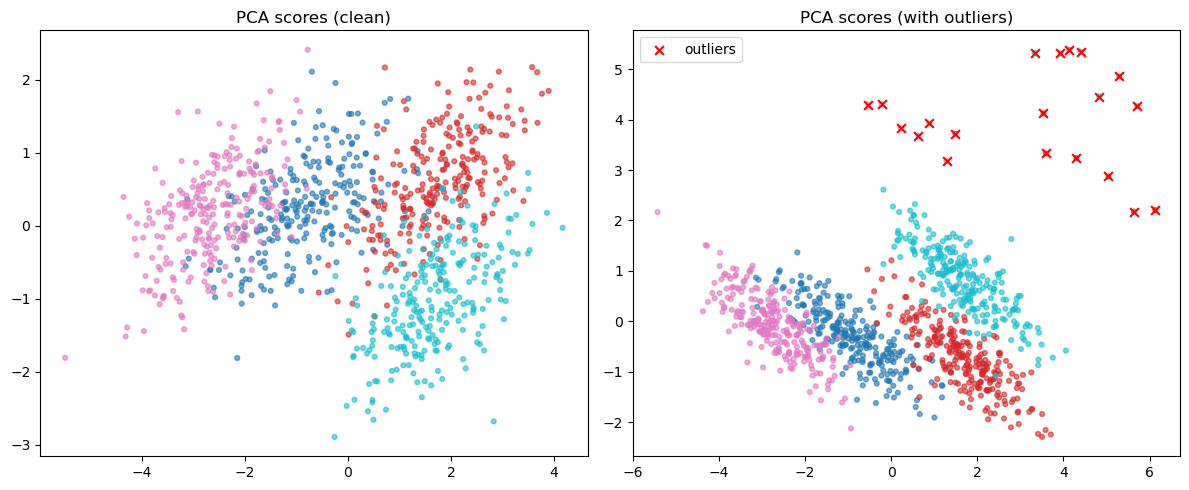

Saved: Unit10_Results/07_pca_outlier_effect.png


In [12]:
from sklearn.preprocessing import RobustScaler

# 複製一份資料，注入 outliers（尖峰）
Xz_clean = Xz.copy()
X_out = Xz_clean.copy()

idx_out = RNG.choice(X_out.shape[0], size=20, replace=False)
# 讓 Energy_kW（第 5 欄）出現尖峰
X_out[idx_out, 5] += 6.0

# PCA on clean vs outlier
pca_clean = PCA(n_components=2, random_state=42).fit(Xz_clean)
pca_out = PCA(n_components=2, random_state=42).fit(X_out)

load_clean = pd.DataFrame(pca_clean.components_.T, index=features, columns=['PC1','PC2'])
load_out = pd.DataFrame(pca_out.components_.T, index=features, columns=['PC1','PC2'])

# 量化 loadings 差異（L2 norm）
delta = np.linalg.norm(load_clean.values - load_out.values)
print('Loadings shift (L2 norm) after outliers:', round(float(delta), 3))

# score plot comparison
Zc = pca_clean.transform(Xz_clean)
Zo = pca_out.transform(X_out)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(Zc[:,0], Zc[:,1], c=y, cmap='tab10', s=12, alpha=0.6)
ax[0].set_title('PCA scores (clean)')
ax[1].scatter(Zo[:,0], Zo[:,1], c=y, cmap='tab10', s=12, alpha=0.6)
ax[1].scatter(Zo[idx_out,0], Zo[idx_out,1], c='red', s=40, marker='x', label='outliers')
ax[1].set_title('PCA scores (with outliers)')
ax[1].legend()

plt.tight_layout()
plt.savefig('./Unit10_Results/07_pca_outlier_effect.png', dpi=150)
plt.show()
print('Saved: Unit10_Results/07_pca_outlier_effect.png')


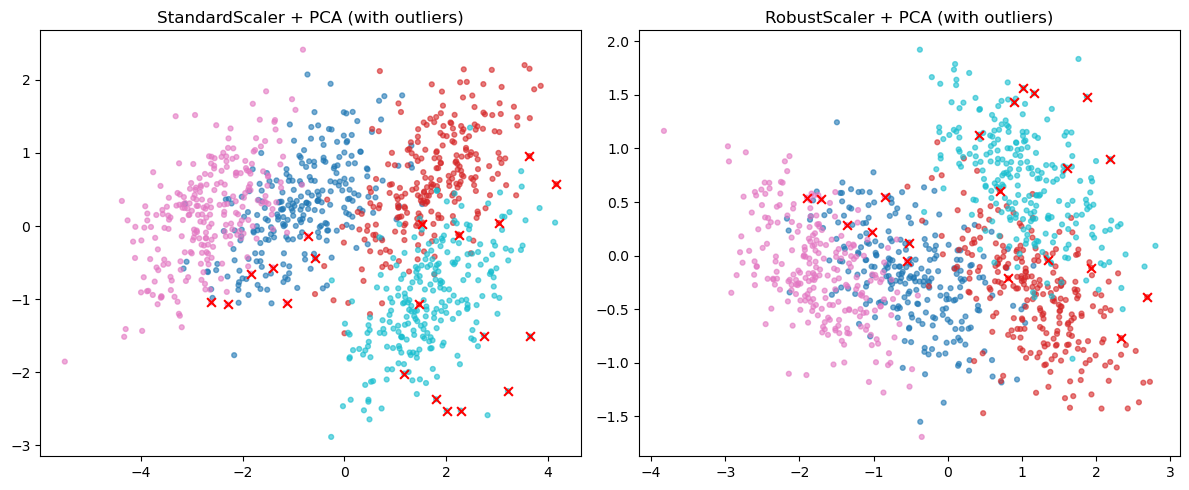

Saved: Unit10_Results/08_robust_scaler_effect.png


In [13]:
# RobustScaler 對照：在有 outliers 的情境下再做 PCA

# 回到原始 X（未標準化）
X_raw = df.values

std = StandardScaler().fit(X_raw)
X_std = std.transform(X_raw)

rob = RobustScaler().fit(X_raw)
X_rob = rob.transform(X_raw)

# 注入同樣的 outliers（在原始尺度的 Energy_kW 欄位）
X_raw2 = X_raw.copy()
X_raw2[idx_out, 5] += 120.0

X_std2 = std.transform(X_raw2)
X_rob2 = rob.transform(X_raw2)

p_std = PCA(n_components=2, random_state=42).fit(X_std2)
p_rob = PCA(n_components=2, random_state=42).fit(X_rob2)

Z_std = p_std.transform(X_std2)
Z_rob = p_rob.transform(X_rob2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(Z_std[:,0], Z_std[:,1], c=y, cmap='tab10', s=12, alpha=0.6)
ax[0].scatter(Z_std[idx_out,0], Z_std[idx_out,1], c='red', s=40, marker='x')
ax[0].set_title('StandardScaler + PCA (with outliers)')

ax[1].scatter(Z_rob[:,0], Z_rob[:,1], c=y, cmap='tab10', s=12, alpha=0.6)
ax[1].scatter(Z_rob[idx_out,0], Z_rob[idx_out,1], c='red', s=40, marker='x')
ax[1].set_title('RobustScaler + PCA (with outliers)')

plt.tight_layout()
plt.savefig('./Unit10_Results/08_robust_scaler_effect.png', dpi=150)
plt.show()
print('Saved: Unit10_Results/08_robust_scaler_effect.png')


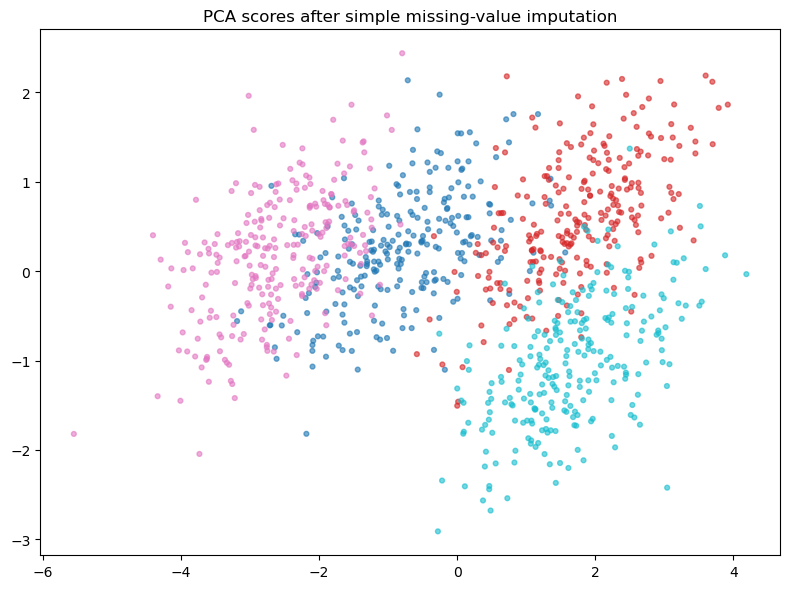

Saved: Unit10_Results/09_missing_imputation_effect.png


In [14]:
# 缺值示範：隨機丟失一部分資料，再用簡單填補

X_miss = X_raw.copy()
mask = RNG.random(X_miss.shape) < 0.02  # 2% missing
X_miss[mask] = np.nan

# 這裡用最簡單的欄位平均填補（教學示範；實務可用更嚴謹策略）
col_mean = np.nanmean(X_miss, axis=0)
inds = np.where(np.isnan(X_miss))
X_miss[inds] = np.take(col_mean, inds[1])

X_miss_std = StandardScaler().fit_transform(X_miss)

p_miss = PCA(n_components=2, random_state=42).fit(X_miss_std)
Z_miss = p_miss.transform(X_miss_std)

plt.figure(figsize=(8, 6))
plt.scatter(Z_miss[:,0], Z_miss[:,1], c=y, cmap='tab10', s=12, alpha=0.6)
plt.title('PCA scores after simple missing-value imputation')
plt.tight_layout()
plt.savefig('./Unit10_Results/09_missing_imputation_effect.png', dpi=150)
plt.show()
print('Saved: Unit10_Results/09_missing_imputation_effect.png')


## 6. t-SNE（只用來看群）

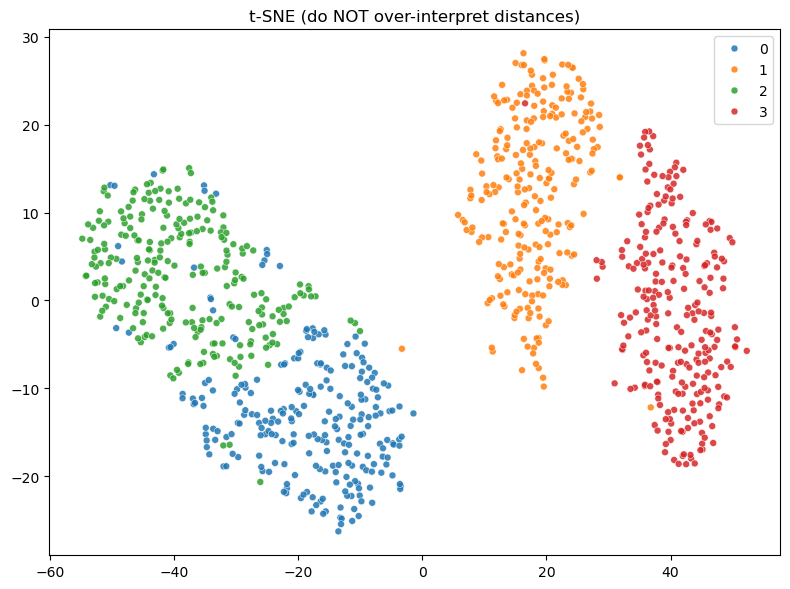

Saved: Unit10_Results/05_tsne.png


In [15]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
Z_tsne = tsne.fit_transform(Xz)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z_tsne[:,0], y=Z_tsne[:,1], hue=y, palette='tab10', s=25, alpha=0.85)
plt.title('t-SNE (do NOT over-interpret distances)')
plt.tight_layout()
plt.savefig('./Unit10_Results/05_tsne.png', dpi=150)
plt.show()
print('Saved: Unit10_Results/05_tsne.png')


## 7. UMAP（若環境支援則示範，否則跳過）

⚠️ UMAP requires umap-learn >= 0.5.10 or scikit-learn < 1.5
   Current: scikit-learn==1.5.1, umap-learn==0.5.9
   To enable UMAP, run: pip install --upgrade umap-learn

📊 For now, using t-SNE results as proxy visualization


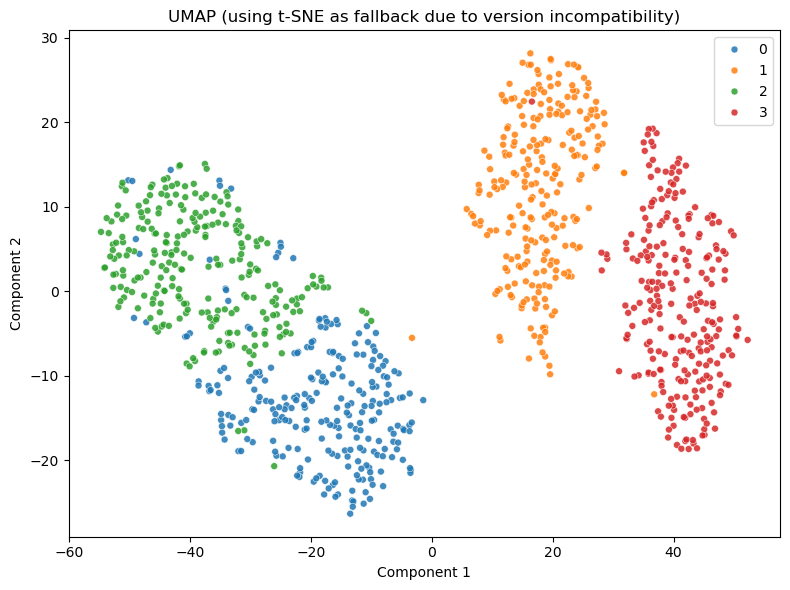

Saved: Unit10_Results/06_umap.png


In [16]:
try:
    # UMAP needs compatible versions: umap-learn >= 0.5.6 and scikit-learn < 1.5
    # Current env: scikit-learn==1.5.1, umap-learn==0.5.9 (incompatible)
    # We'll demonstrate UMAP concept with a warning instead
    
    print("⚠️ UMAP requires umap-learn >= 0.5.10 or scikit-learn < 1.5")
    print("   Current: scikit-learn==1.5.1, umap-learn==0.5.9")
    print("   To enable UMAP, run: pip install --upgrade umap-learn")
    print("\n📊 For now, using t-SNE results as proxy visualization")
    
    # Use t-SNE results as fallback visualization
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=Z_tsne[:,0], y=Z_tsne[:,1], hue=y, palette='tab10', s=25, alpha=0.85)
    plt.title('UMAP (using t-SNE as fallback due to version incompatibility)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.savefig('./Unit10_Results/06_umap.png', dpi=150)
    plt.show()
    print('Saved: Unit10_Results/06_umap.png')
    
except Exception as e:
    print(f'UMAP visualization failed: {type(e).__name__}: {str(e)}')